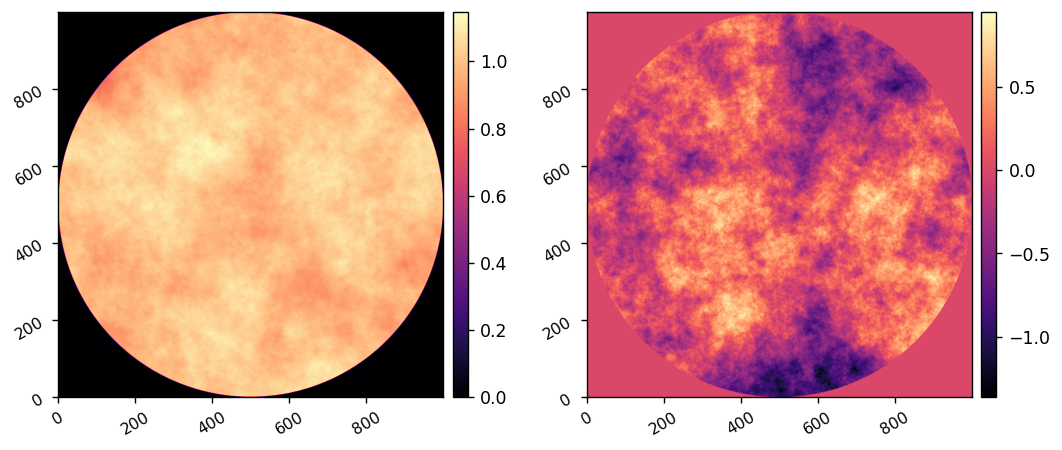

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.scoob_rmad as rmad
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc as adefc

wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)



# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


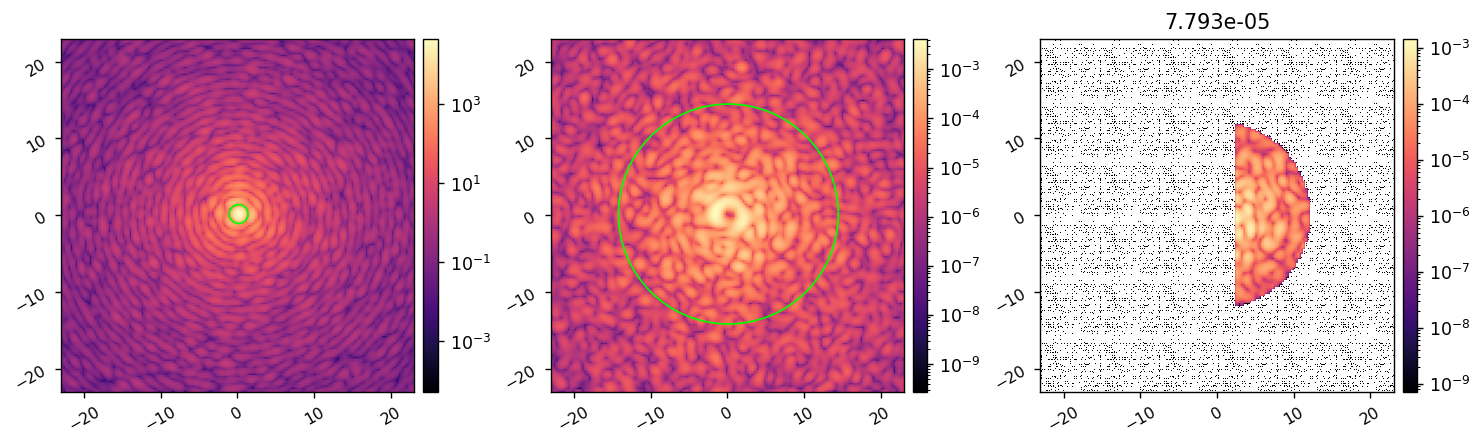

In [49]:
reload(rmad)
I = rmad.MODEL()
I.WFE = WFE
# I.flip_dm = 1

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 2.5
owa = 12
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamD/2, I.psf_pixelscale_lamD/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamD, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')])

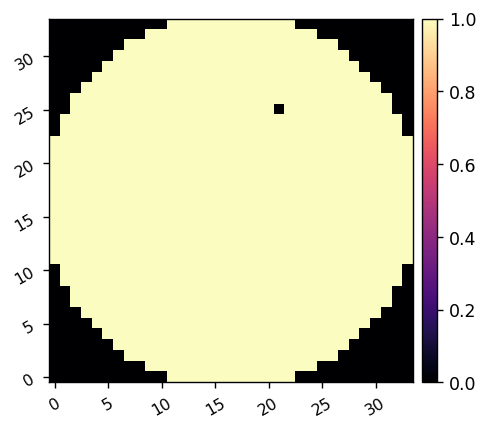

In [31]:
imshow1(I.dm_mask)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


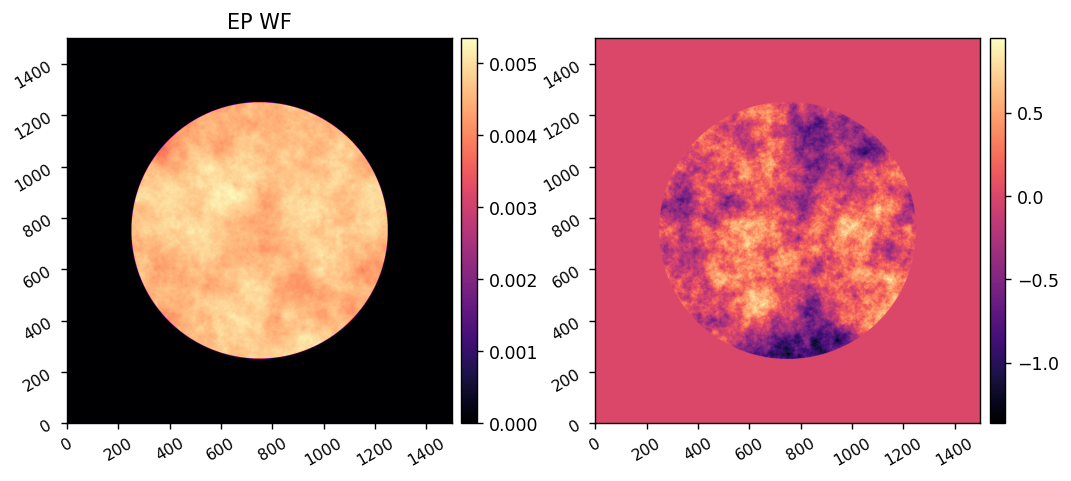

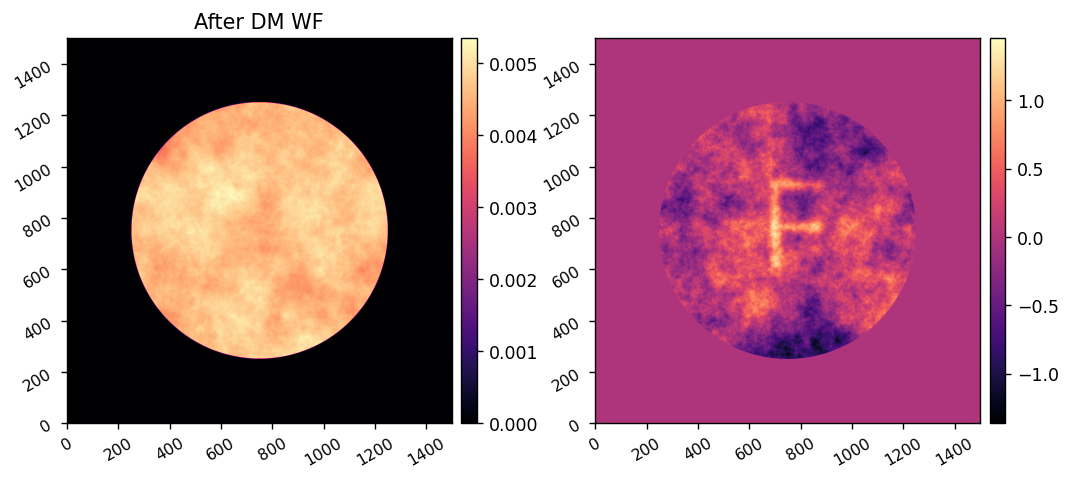

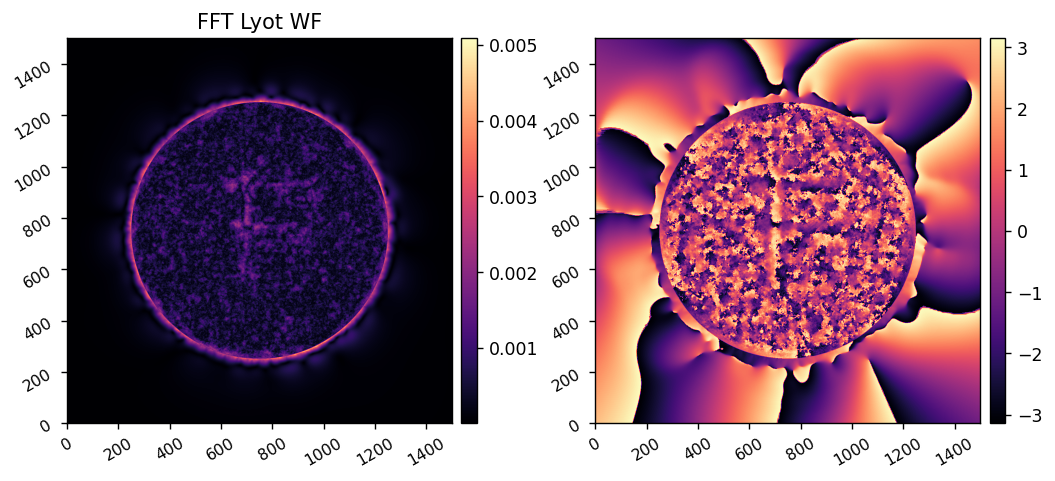

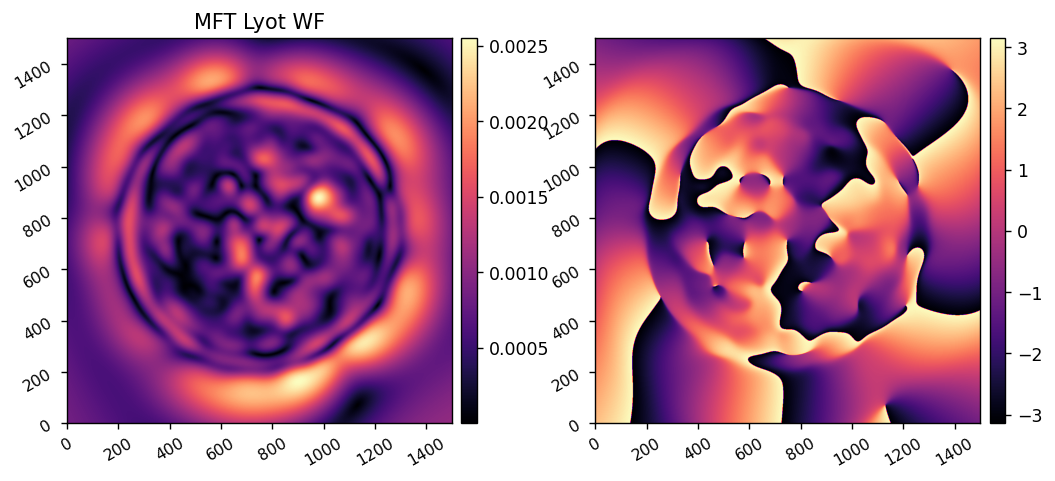

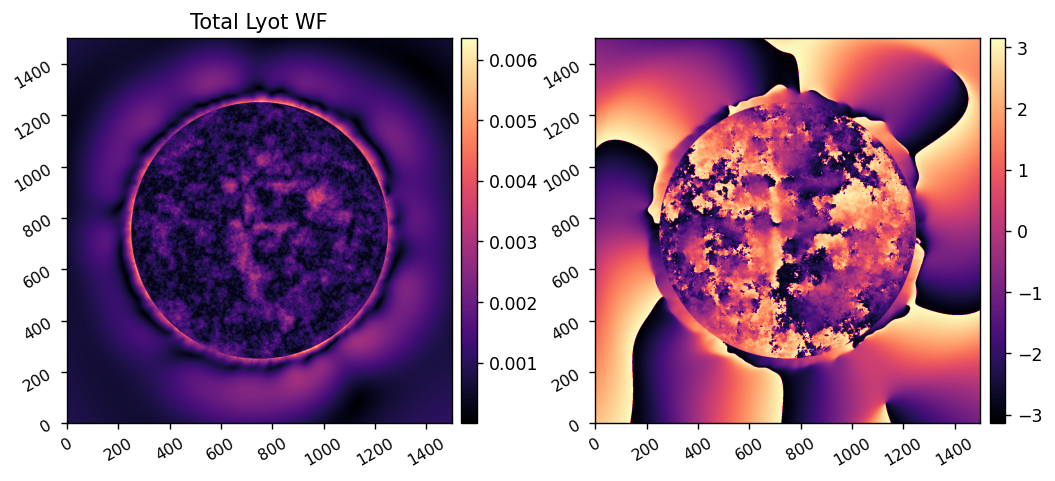

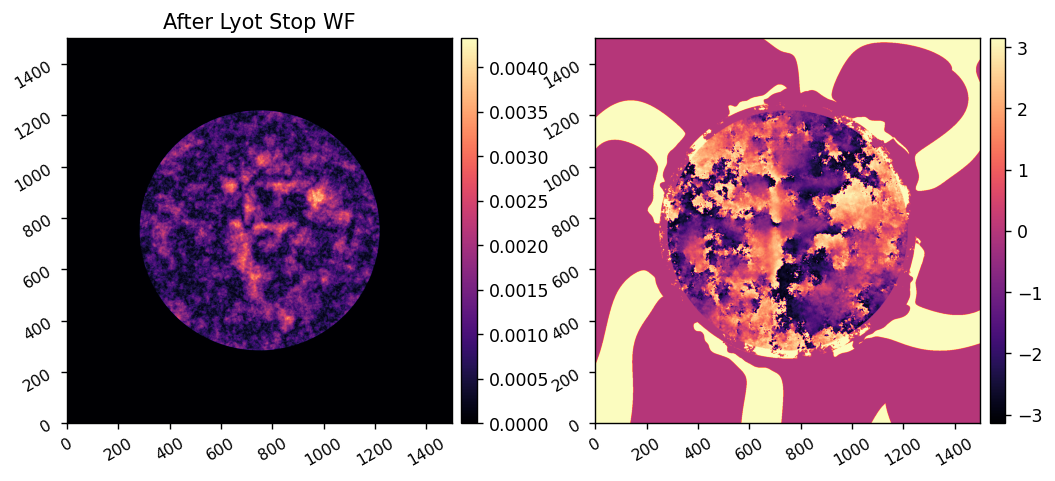

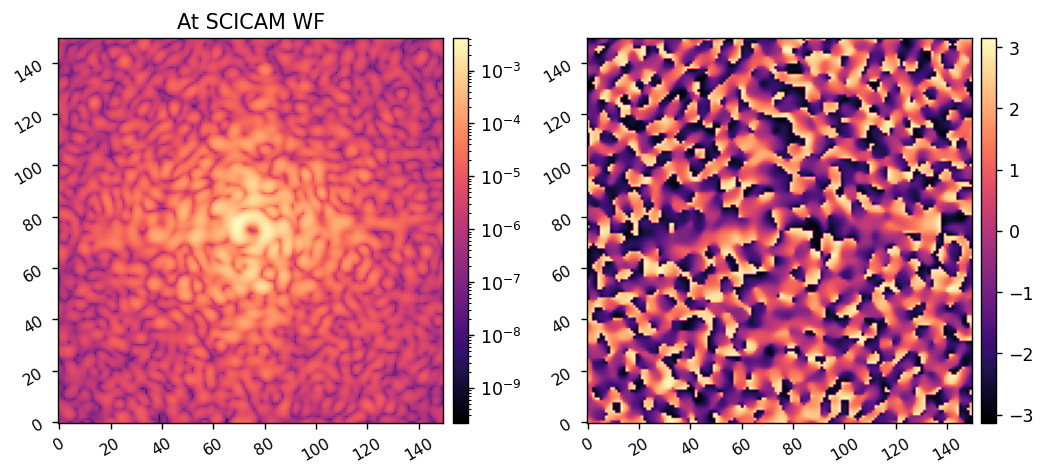

In [50]:
reload(rmad)
reload(scoobpsf.dm)
M = rmad.MODEL()
M.WFE = WFE

# M.flip_dm = 1

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

# fpwf = M.forward(np.zeros(M.Nacts), use_vortex=True, plot=True)

F = 30e-9*lina.utils.make_f(h=10, w=6, shift=(0,0))
fpwf = M.forward(F[M.dm_mask], use_vortex=True, plot=True)


	Cost-function J_delE: 0.139
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.139
	Total cost-function value: 1.000



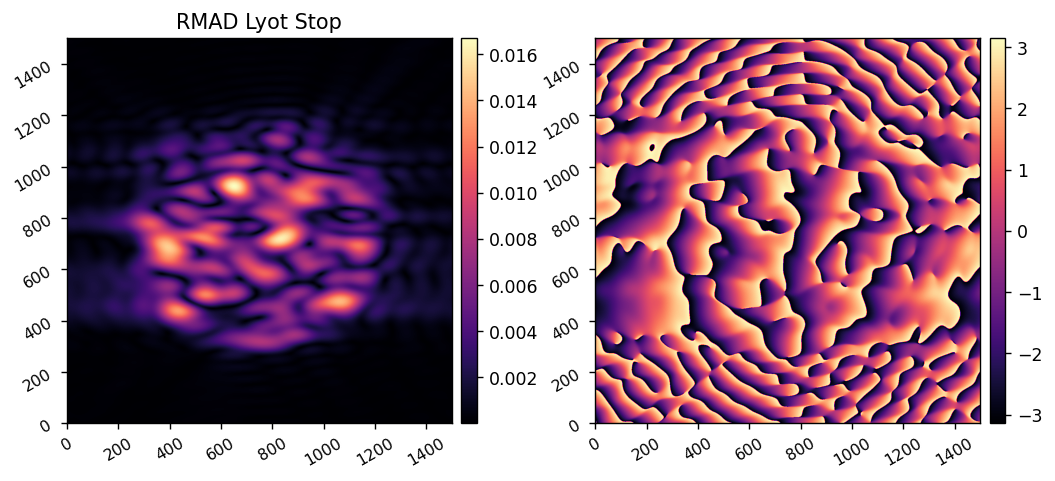

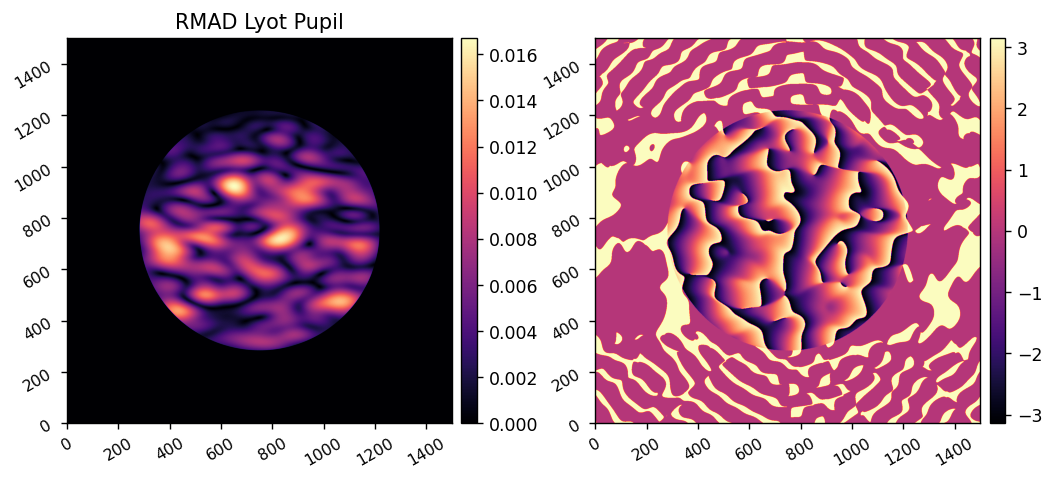

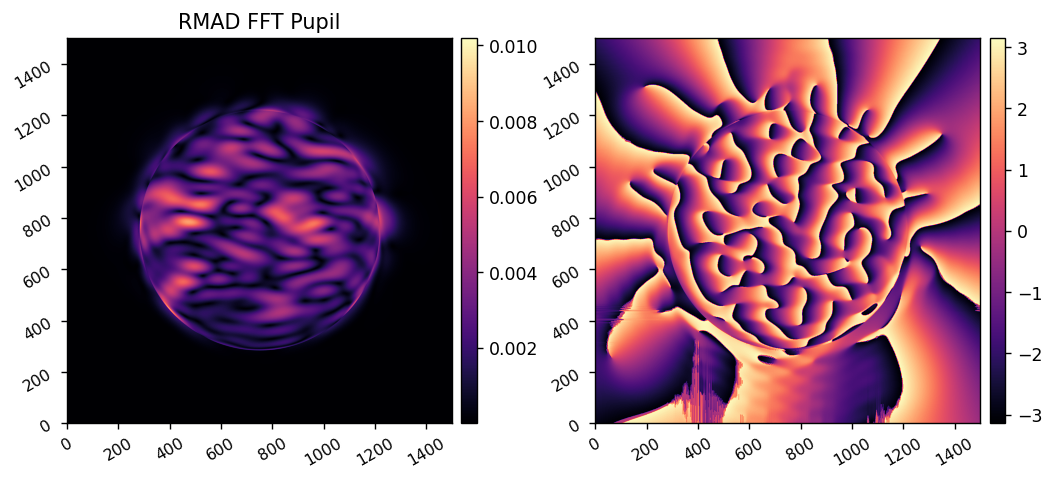

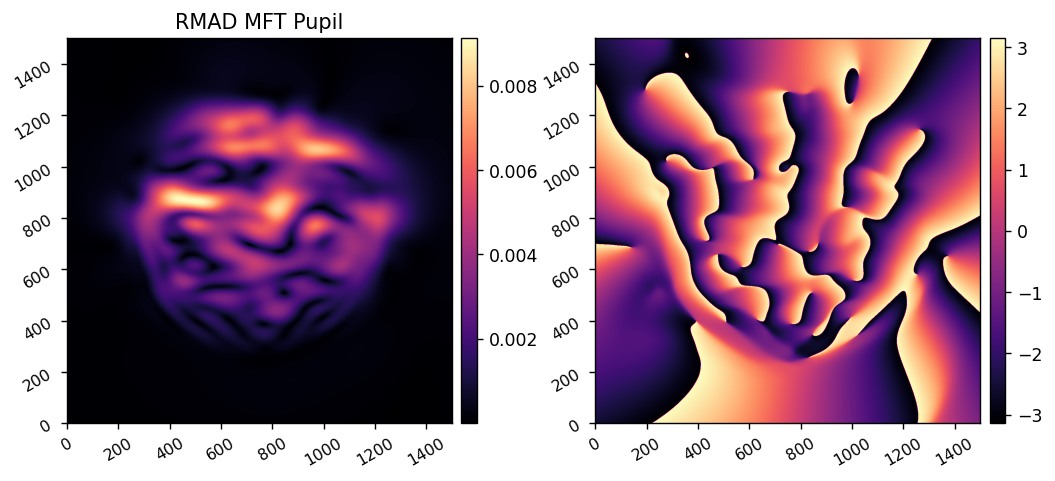

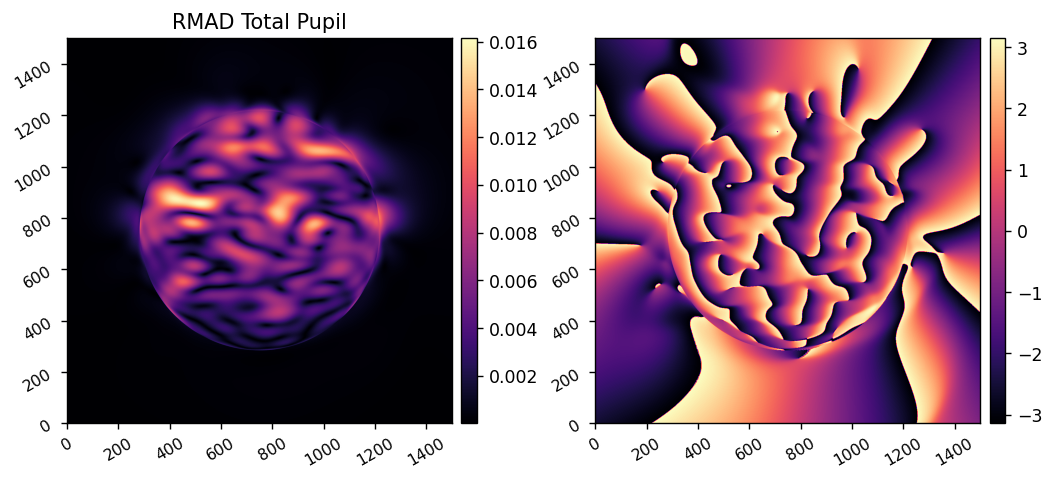

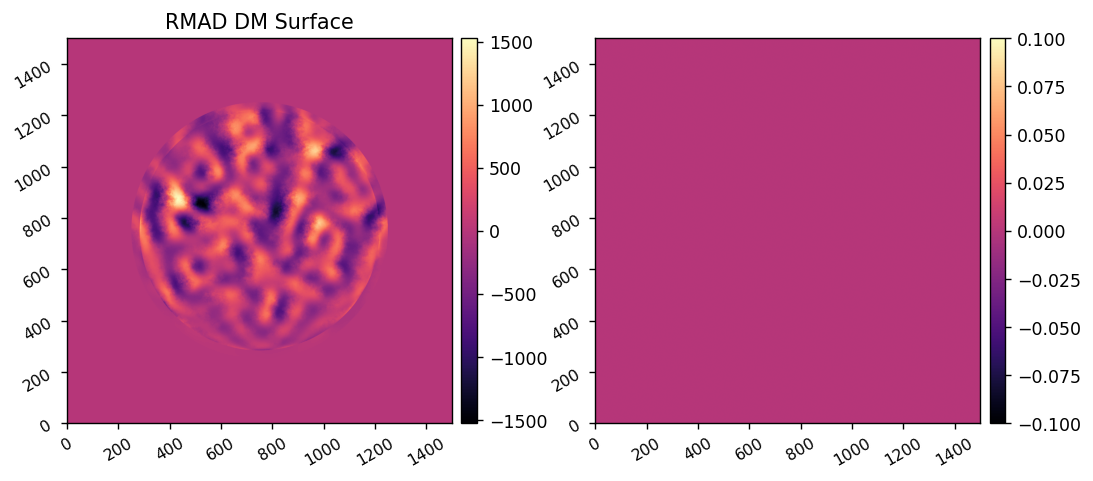

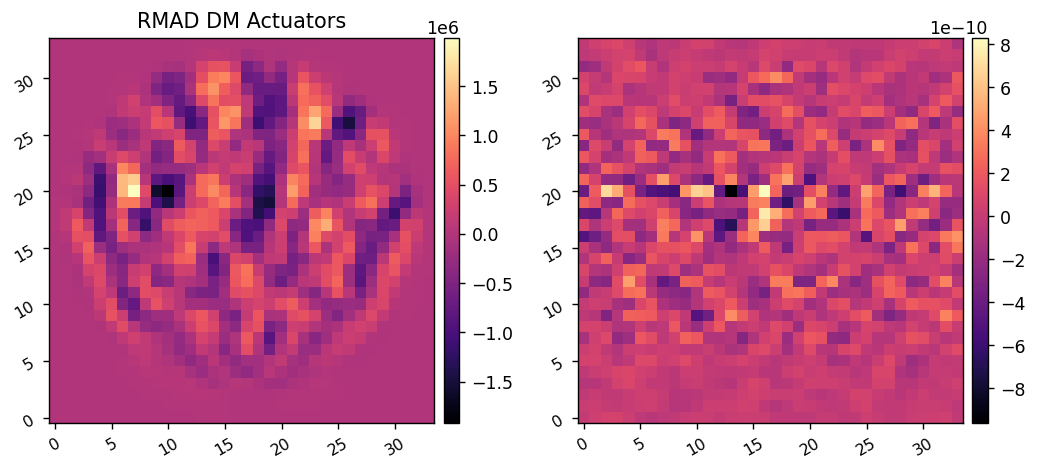

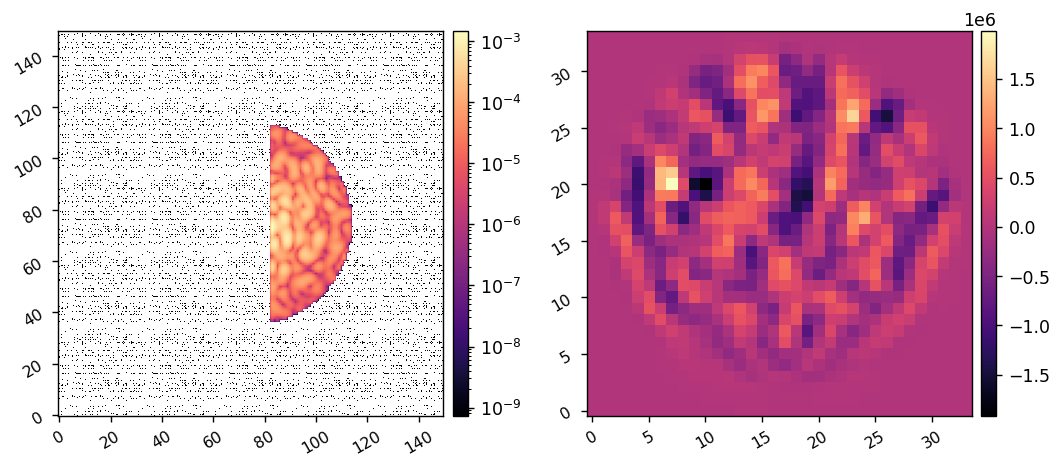

In [51]:
reload(rmad)

acts = np.zeros(I.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
r_cond = 1e-2

del_acts = np.zeros(M.Nacts)
J, dJ_dA = rmad.val_and_grad(del_acts, M, acts, E_ab, r_cond, control_mask, verbose=True, plot=True)

dm_grad = rmad.acts_to_command(dJ_dA, M.dm_mask)
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [47]:

acts = np.zeros(I.Nacts)
acts = fits.getdata('ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(rmad.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(M, acts, E_ab, r_cond, control_mask, True, False), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.50208D+07
	Cost-function J_delE: 0.003
	Cost-function J_c: 2495701154.761
	Cost-function normalization factor: 0.001
	Total cost-function value: 4330500660039.000

	Cost-function J_delE: 2.274
	Cost-function J_c: 0.027
	Cost-function normalization factor: 0.001
	Total cost-function value: 3992.742

	Cost-function J_delE: 0.096
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 166.739

	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 0.871


At iterate    1    f=  8.70886D-01    |proj g|=  7.13385D+06


 This problem is unconstrained.


	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 0.821


At iterate    2    f=  8.21177D-01    |proj g|=  4.77224D+06
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 0.680


At iterate    3    f=  6.79753D-01    |proj g|=  4.83688D+06
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 0.605


At iterate    4    f=  6.04863D-01    |proj g|=  7.53700D+06
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 0.506


At iterate    5    f=  5.06094D-01    |proj g|=  4.93128D+06
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.001
	Total cost-function value: 0.447


At iterate    6    f=  4.47111D-01    |proj g|=  7.00287D+06
	Cost-function J_delE: 0.

0.0


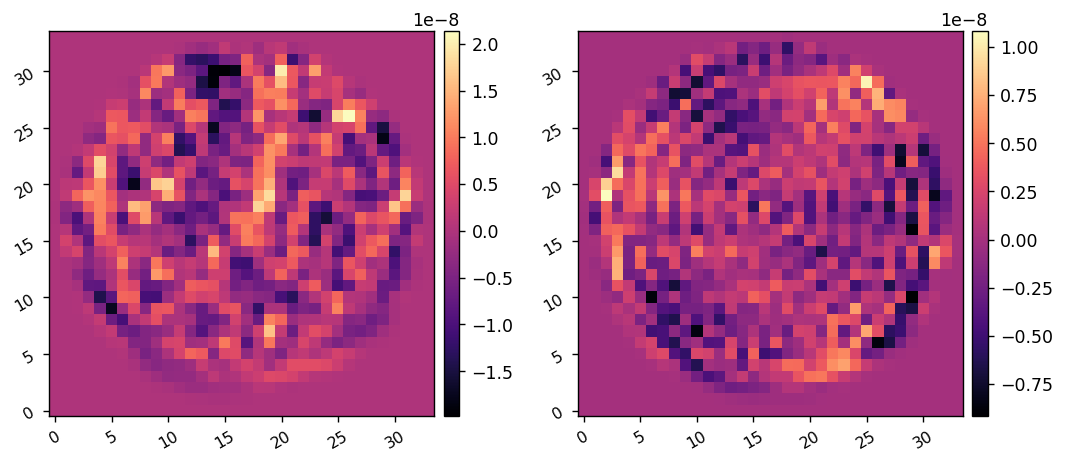

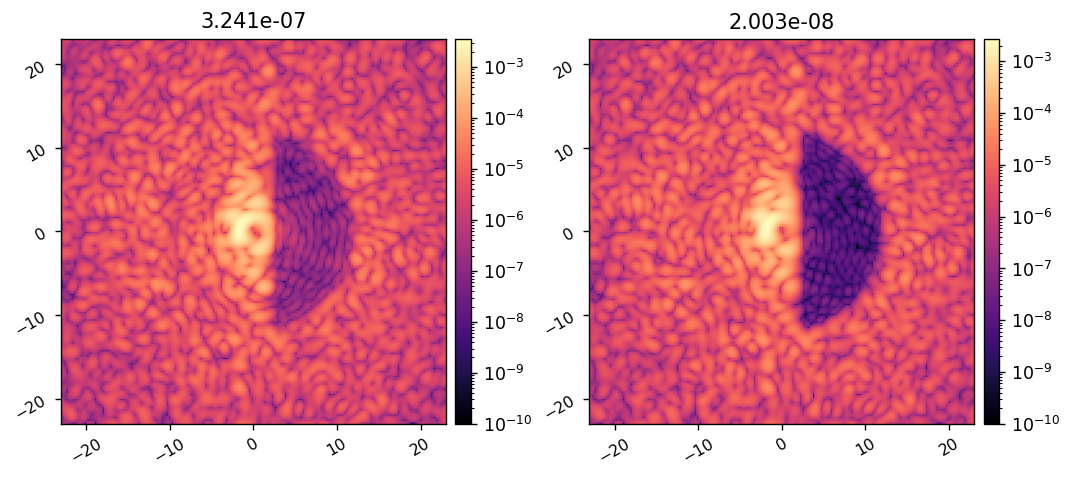

In [48]:
old_command = rmad.acts_to_command(acts, I.dm_mask)
del_command = rmad.acts_to_command(res.x, I.dm_mask)
print(del_command[25,21])

I.set_dm(old_command)
old_im = I.snap()
I.set_dm(old_command + del_command)
new_im = I.snap()

imshow2(old_command, del_command)
imshow2(old_im, new_im, 
        f'{xp.mean(old_im[control_mask]):.3e}', f'{xp.mean(new_im[control_mask]):.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamD, vmin1=1e-10, vmin2=1e-10)

In [46]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits
